**Word2vec**

It's easy to use one-hot algorithm to represent every word appearing in all the texts. However, there'll be two major problems with this method. First, since all the word is represented by a **[1 * the size of vocabulary]** dimension vector, it's hard to store or use such a "large" vector. Second, because all the elements in vectors are zero expect only one element, two representations of words are **orthogonal**， which means no words are similar to each other (impossible in the real condition).

In this case, we need a better way to represent words. When we talk about the representation of words, we are actually talking about how to use vector to express the meaning of the words. Normally, if we want to know the meaning of a word, we should not only check the meaning of **itself**, but also check the meaning of its **context**. Based on this, people first came up with a idea called **CBOW**, that is, generating a representation of a word by using the context to predict it.  

If we have context words $c_1, c_2, ..., c_{i-1}, c_{i+1}, ..., c_n$, and we want to know $c_i$, which is the center word, what should we do? We should calculate the probability of all the possible words appearing as $c_i$ and use the one having the maximum probability. The formula is $P(c_i|c_1, c_2, ..., c_{i-1}, c_{i+1}, ..., c_n)$. An important assumption is that all the words are independent, so we could change the formula to $∏P(c_i|c_j)$, where j is from 1 to n except i. We want to maximize the probability so the prediction is like this:

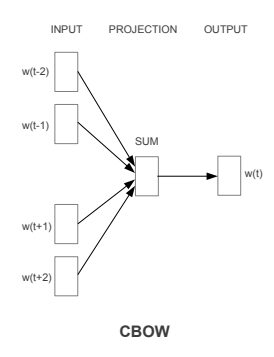

However, this method has its own flaws. If we build a neural network model to behave like this, the procedure is:

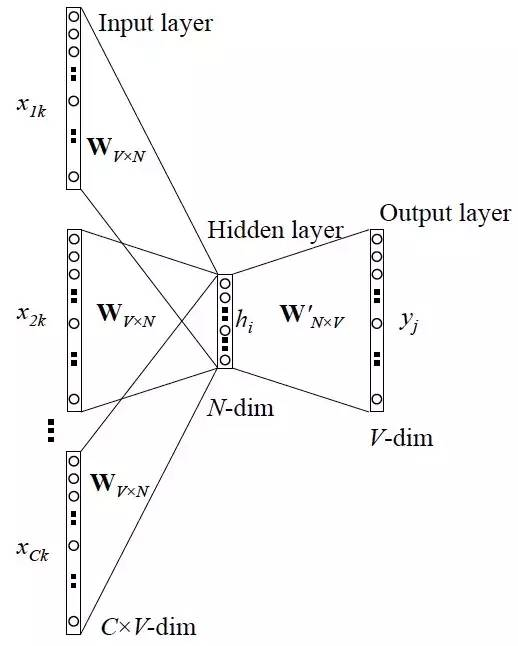

We use many context words to predict just one word, and adjust the representations of context words **simultaneously**. Although in this way, we could save running time (because the times of prediction are equal to the size of the vocabulary), updating representations of all context words using same gradient would have negative influence on the accuracy.

In order to address this problem, people come up with another idea: using center word to predict context words. This algorithm is called **skip-gram**, and the probability is $P(c_1, c_2, ..., c_{i-1}, c_{i+1}, ..., c_n|c_i)$. After changing the form: $∏P(c_j|c_i)$, where j is from 1 to n except i. We want to maximize this probability, so the prediction is like: 

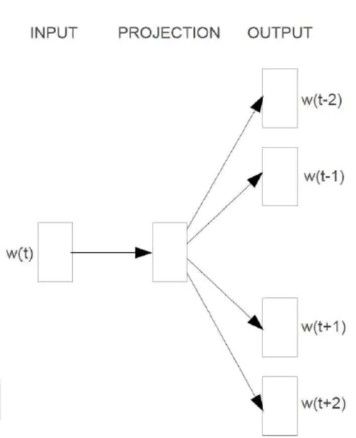

The prediction would like this, that is, for each center word, using context words to update the representation:

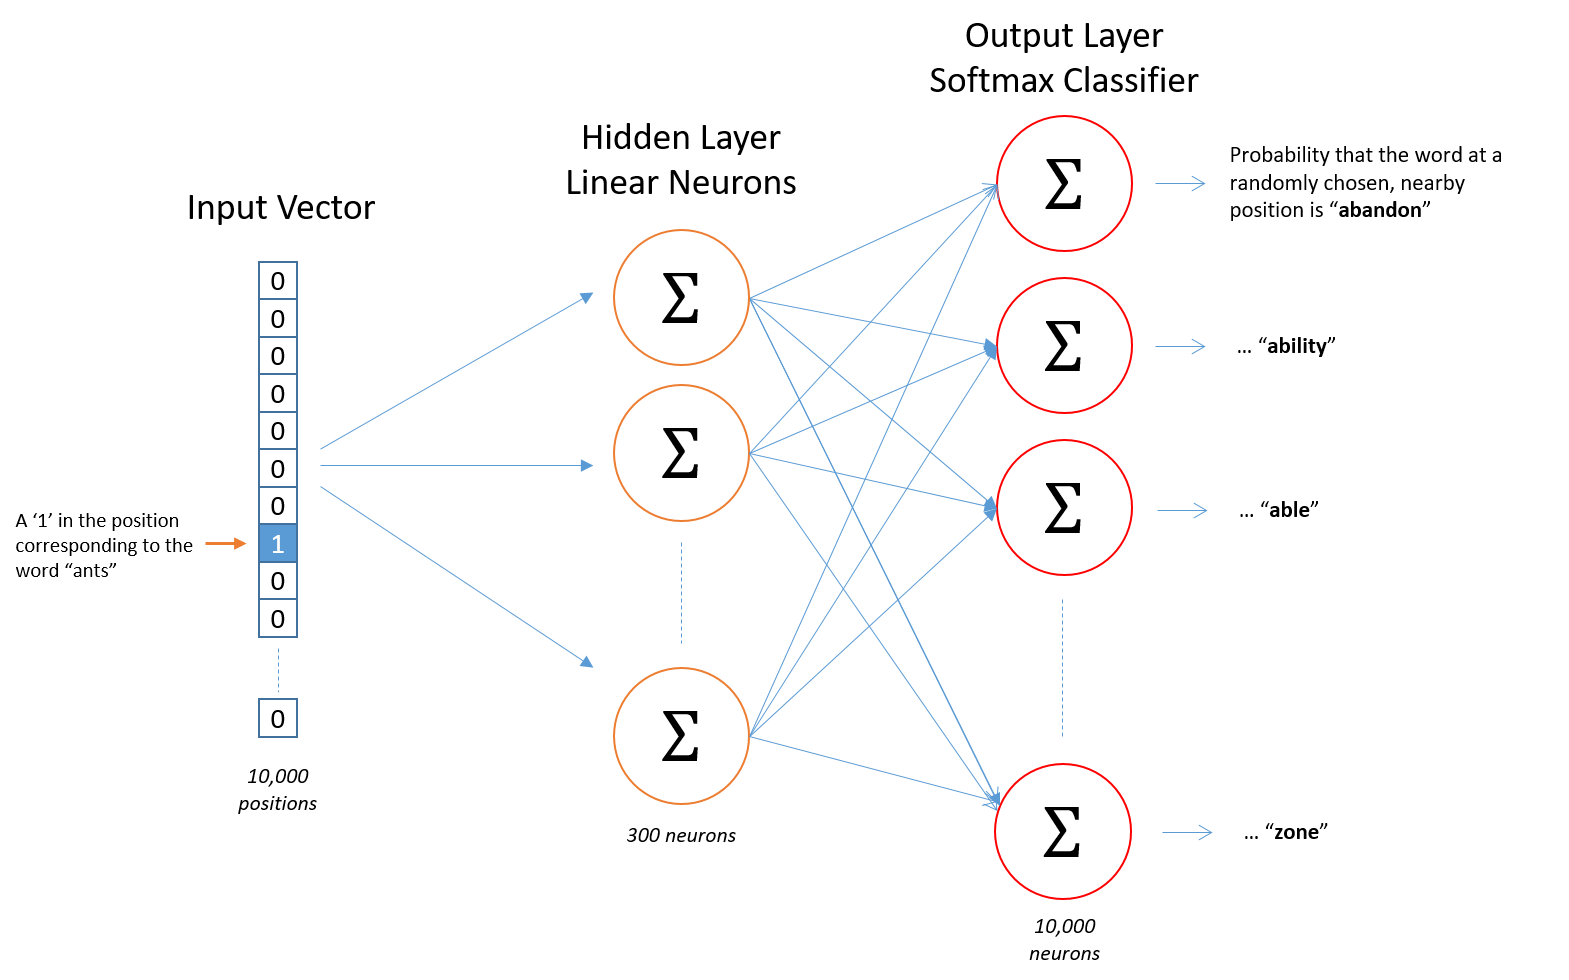

This time, we improve the performance of the model but use more time(to update representation of one word, we should predict k times context words). To reduce the running time for skip-gram, we could use **negative sampling** and **hierarchical softmax**. 

Since we actually want to learn the representation of nodes in graphs, how could skip-gram benefit graph learning? In fact, we could see each sentence as a sequence of nodes. If we randomly walk on our graph, we could get several "sentences". After generating these sentences, we could perform skip-gram on them to get the representation of all the nodes. This algorithm is called **Deepwalk**, which would be discussed in the next jupyter.

In [ ]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar zxf aclImdb_v1.tar.gz

--2022-03-04 12:19:40--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  19.2MB/s    in 7.8s    

2022-03-04 12:19:48 (10.3 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
import os
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

Preprocessing the text data, we would like to get a sequences of sequences of words, which could be gained by separating sentences. In order to reduce the size of the vocabulary, we could just remain all the characters and numbers. As we discussed above, we should also map each word to a id and a one-hot vector. To reduce the running time of our word2vec model, we could also set the maximum size of vocabulary, that is, only including the words have relatively high frequency and setting the other words to \<unknow\> type.

In [ ]:
def remove_tags(text):
  tags = re.compile(r'<[^>]+>')
  result = tags.sub(' ', text)
  return re.sub(r'([^\s\w]|_)+', '', result)

def get_imdb(mode):
  filedir = os.path.join('aclImdb', mode)
  negdir = os.path.join(filedir, 'neg')
  posdir = os.path.join(filedir, 'pos')
  fs = []
  for filename in os.listdir(negdir):
    f = os.path.join(negdir, filename)
    fs.append(f)
  for filename in os.listdir(posdir):
    f = os.path.join(posdir, filename)
    fs.append(f)
  texts = []
  for f in fs:
    with open(f, encoding='utf8') as inputf:
      texts += [remove_tags(' '.join(inputf.readlines())).lower().split()]
  return texts

texts = get_imdb('train')
texts += get_imdb('test')

In [ ]:
print(texts[0])

['this', 'movie', 'was', 'terrible', 'the', 'plot', 'sucked', 'the', 'acting', 'was', 'bad', 'the', 'editing', 'was', 'inept', 'and', 'this', 'movie', 'makes', 'me', 'want', 'to', 'poke', 'my', 'eyes', 'out', 'i', 'wish', 'i', 'had', 'the', 'time', 'i', 'spent', 'watching', 'this', 'movie', 'back', 'the', 'balloon', 'scene', 'was', 'stupid', 'the', 'mormon', 'jokes', 'are', 'really', 'old', 'the', 'soundtrack', 'sucked', 'i', 'saw', 'no', 'chemistry', 'between', 'the', 'two', 'leads', 'its', 'full', 'of', 'stereotypes', 'stupid', 'local', 'celeb', 'cameosmost', 'noted', 'was', 'del', 'im', 'going', 'to', 'drive', 'as', 'fast', 'as', 'i', 'want', 'to', 'computer', 'idiot', 'what', 'is', 'worst', 'is', 'that', 'these', 'actors', 'had', 'to', 'play', 'themselves', 'on', 'the', 'spiritual', 'side', 'and', 'even', 'they', 'screwed', 'that', 'up', 'this', 'movie', 'help', 'create', 'a', 'long', 'line', 'of', 'lackluster', 'efforts', 'to', 'mainstream', 'lds', 'beliefs', 'into', 'hollywood', 

In [ ]:
sample_texts = random.sample(texts, 100)

In [ ]:
def gen_wordid(texts):
  id2word = {}
  word2id = {}
  count = 0
  for text in texts:
    for word in text:
      if word not in word2id:
        id2word[count] = word
        word2id[word] = count
        count += 1
  return id2word, word2id
id2word, word2id = gen_wordid(sample_texts)

In [ ]:
print(len(word2id))

5194


In [ ]:
epoch = 500
windowsz = 1
lr = 0.01
batch = 64
wordsz = len(word2id)
featuresz = 16

In [ ]:
def one_hot(word):
  vec = [0] * wordsz
  vec[word2id[word]] = 1
  return vec

def gen_data(texts):
  sources = []
  targets = []
  for text in texts:
    for i, word in enumerate(text):
      source = one_hot(word)
      for j in range(i - windowsz, i + windowsz + 1):
        if j != i and j >= 0 and j < len(text):
          target = word2id[text[j]]
          sources.append(source)
          targets.append(target)
  return torch.Tensor(sources), torch.tensor(targets)

sources, targets = gen_data(sample_texts)

In [ ]:
print(sources.shape)

torch.Size([48164, 5194])


Build the model as we discussed before. Remember the weight of first Linear layer(input to hidden layer) is the representation of all words. And the CrossEntropyLoss of nn includes softmax, so we don't need to include softmax layer in our model. 

Why would we choose the first layer instead of the second one? If we check the precedure of the algorithm, we first use **all zero vector(except the ith element is 1)** and multiply the weight of the first layer. What we acually do is get the **ith row** of the weight as the representation of our input word, so the weight of the first layer could be representations of all words.

Some people do research on the second layer and claim they could use this layer to improve the performace of the model.

In [ ]:
class word2vec(nn.Module):
  def __init__(self):
    super(word2vec, self).__init__()
    self.layer1 = nn.Linear(wordsz, featuresz)
    self.layer2 = nn.Linear(featuresz, wordsz)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [ ]:
model = word2vec()
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = torch.utils.data.TensorDataset(sources, targets)
train_loader = DataLoader(trainset, batch_size=batch, shuffle=True)

In [ ]:
def train():
  model.train()
  for i in range(epoch):
    acc = 0
    for x, y in train_loader:
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print("epoch: {0}, loss: {1}".format(i, loss))

In [ ]:
train()

epoch: 0, loss: 8.52313232421875
epoch: 1, loss: 8.465963363647461
epoch: 2, loss: 8.045125961303711
epoch: 3, loss: 7.634568214416504
epoch: 4, loss: 7.393664836883545
epoch: 5, loss: 6.7953033447265625
epoch: 6, loss: 7.103667736053467
epoch: 7, loss: 6.503381729125977
epoch: 8, loss: 6.897639751434326
epoch: 9, loss: 6.963071346282959
epoch: 10, loss: 6.506505012512207
epoch: 11, loss: 6.182908535003662
epoch: 12, loss: 6.717868328094482
epoch: 13, loss: 6.360657215118408
epoch: 14, loss: 7.1561737060546875
epoch: 15, loss: 6.7358317375183105
epoch: 16, loss: 6.571172714233398
epoch: 17, loss: 7.523801803588867
epoch: 18, loss: 6.270759582519531
epoch: 19, loss: 7.274396896362305
epoch: 20, loss: 6.643966197967529
epoch: 21, loss: 6.047751426696777
epoch: 22, loss: 6.542032241821289
epoch: 23, loss: 7.395540237426758
epoch: 24, loss: 6.510523796081543
epoch: 25, loss: 6.945941925048828
epoch: 26, loss: 6.451262950897217
epoch: 27, loss: 7.181451797485352
epoch: 28, loss: 6.740777969

In [ ]:
embedding = model.layer1.weight.T
similaity = F.cosine_similarity(embedding.unsqueeze(1), embedding.unsqueeze(0), dim=2)
a, idx = torch.sort(similaity, descending=True)
k = 3
lists=idx[:,:k]
for i in range(100):
  print("[{0}] is similar to ".format(id2word[i]), end="")
  for j in range(k):
    print("[{0}]".format(id2word[int(lists[i][j])]), end=" ")
  print()


[written] is similar to [written] [shayne] [jane] 
[by] is similar to [by] [military] [music] 
[directed] is similar to [directed] [mail] [sick] 
[and] is similar to [and] [army] [woodsilver] 
[starring] is similar to [starring] [slim] [settings] 
[the] is similar to [the] [johnny] [central] 
[champ] is similar to [champ] [hands] [russia] 
[of] is similar to [of] [articulacy] [primitive] 
[camp] is similar to [camp] [path] [cause] 
[bruce] is similar to [bruce] [benton] [picks] 
[campbell] is similar to [campbell] [fans] [utterly] 
[easy] is similar to [easy] [resemblance] [muscle] 
[on] is similar to [on] [maybe] [into] 
[its] is similar to [its] [mh] [themes] 
[to] is similar to [to] [resist] [coyote] 
[tell] is similar to [tell] [find] [sent] 
[this] is similar to [this] [impressionistic] [revolves] 
[is] is similar to [is] [was] [necessarily] 
[a] is similar to [a] [rammed] [lotta] 
[budget] is similar to [budget] [nail] [mainstream] 
[shoestring] is similar to [shoestring] [consta